### Core Imports

In [93]:
# Import necessary libraries
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Import preprocessing and model selection modules from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

# Import evaluation metrics from scikit-learn
from sklearn.metrics import (
   mean_squared_error,
   mean_absolute_error,
   r2_score,
   max_error,
)

# Import various models from scikit-learn and other libraries
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Data Loading + Preprocessing

In [94]:
# Base path to data files
base_path = './data/clean/working-futures-2024/regions/'
combined_file_path = os.path.join(base_path, 'combined_data.csv')

# Glob to find all CSV files
file_paths = glob(base_path + '*.csv')

# Mappings for categorical data
gender_map = {1: 'Male', 2: 'Female'}
status_map = {1: 'Full Time', 2: 'Part Time', 3: 'Self Employed'}
country_map = {
   'EN': 'England',
   'WA': 'Wales',
   'NI': 'Northern Ireland',
   'SC': 'Scotland',
   'UK': 'United Kingdom'
}
occupation_map = {
   1: 'Corporate managers and directors',
   2: 'Other managers and proprietors',
   3: 'Science, research, engineering and technology professionals',
   4: 'Health professionals',
   5: 'Teaching and educational professionals',
   6: 'Business, media and public service professionals',
   7: 'Science, engineering and technology associate professionals',
   8: 'Health and social care associate professionals',
   9: 'Protective service occupations',
   10: 'Culture, media and sports occupations',
   11: 'Business and public service associate professionals',
   12: 'Administrative occupations',
   13: 'Secretarial and related occupations',
   14: 'Skilled agricultural and related trades',
   15: 'Skilled metal, electrical and electronic trades',
   16: 'Skilled construction and building trades',
   17: 'Textiles, printing and other skilled trades',
   18: 'Caring personal service occupations',
   19: 'Leisure, travel and related personal service occupations',
   20: 'Sales occupations',
   21: 'Customer service occupations',
   22: 'Process, plant and machine operatives',
   23: 'Transport and mobile machine drivers and operatives',
   24: 'Elementary trades and related occupations',
   25: 'Elementary administration and service occupations'
}
qualification_map = {
   1: 'Doctorate (QCF8)',
   2: 'Other higher degree (QCF7)',
   3: 'First degree (QCF6)',
   4: 'Foundation degree; Nursing; Teaching (QCF5)',
   5: 'HE below degree level (QCF4)',
   6: 'A level & equivalent (QCF3)',
   7: 'GCSE (A-C) & equivalent (QCF2)',
   8: 'GCSE (below grade C) & equivalent (QCF1)',
   9: 'No Qualification'
}

In [95]:
# Check if the combined file already exists
if os.path.exists(combined_file_path):
   # Load the combined file
   combined_df = pd.read_csv(combined_file_path)
else:
   # Initialize a list to hold DataFrames
   all_dataframes = []
   
   # Iterate over each file path
   for file_path in file_paths:
       # Extract country and industry information from filename
       filename = os.path.basename(file_path)
       parts = filename.split('_')
       country_code = parts[0][2:]
       industry_code = parts[1].split('.')[0]
       
       # Read the CSV file
       df = pd.read_csv(file_path)
       
       # Map categorical values to their corresponding labels
       df['gender'] = df['gender'].map(gender_map)
       df['status'] = df['status'].map(status_map)
       df['occupation'] = df['occupation'].map(occupation_map)
       df['qualification'] = df['qualification'].map(qualification_map)
       
       # Add industry and country identifier columns
       df['industry'] = industry_code  # Add the industry code as a new column
       df['country'] = country_map[country_code]  # Map the country code to its name and add as a new column
       
       # Append the DataFrame to the list if country_code is not 'UK'
       if country_code != 'UK':
           all_dataframes.append(df)
   
   # Concatenate all DataFrames into one
   combined_df = pd.concat(all_dataframes, ignore_index=True)
   
   # Melt the DataFrame to reshape it
   combined_df = combined_df.melt(
       id_vars=['gender', 'status', 'occupation', 'qualification', 'industry', 'country'],
       var_name='year',
       value_name='labour_workforce'
   )
   
   # Convert the 'year' column to integer
   combined_df['year'] = combined_df['year'].astype(int)
   
   # Save the combined DataFrame to CSV in the base path
   combined_df.to_csv(combined_file_path, index=False)

print("DataFrame is loaded in.")

DataFrame is loaded in.


### Feature Engineering
Removed polynomial, interaction, year-based, statistical (std, median, rolling etc.) as they did not help models at all.

In [96]:
# Add lag features
combined_df['labour_workforce_lag1'] = combined_df.groupby(['gender', 'status', 'occupation', 'qualification', 'industry', 'country'])['labour_workforce'].shift(1)
combined_df['labour_workforce_lag2'] = combined_df.groupby(['gender', 'status', 'occupation', 'qualification', 'industry', 'country'])['labour_workforce'].shift(2)
combined_df['labour_workforce_lag3'] = combined_df.groupby(['gender', 'status', 'occupation', 'qualification', 'industry', 'country'])['labour_workforce'].shift(3)
# combined_df['labour_workforce_lag4'] = combined_df.groupby(['gender', 'status', 'occupation', 'qualification', 'industry', 'country'])['labour_workforce'].shift(4)
# combined_df['labour_workforce_lag5'] = combined_df.groupby(['gender', 'status', 'occupation', 'qualification', 'industry', 'country'])['labour_workforce'].shift(5)

# Drop rows with missing values
combined_df = combined_df.dropna()

# Prepare the data
X = combined_df[['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3']]  # 'labour_workforce_lag4', 'labour_workforce_lag5']]
y = combined_df['labour_workforce']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Searching using CV

In [97]:
# Parameter grids for grid search
enet_param_grid = {
   'alpha': [0.01, 0.1, 1.0, 10.0, 100],
   'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
   'max_iter': [1000, 2000, 5000]
}

knn_param_grid = {
   'n_neighbors': [3, 5, 7, 9, 11],
   'weights': ['uniform', 'distance'],
   'metric': ['euclidean', 'manhattan']
}

xgb_param_grid = {
   'n_estimators': [25, 50, 100],
   'max_depth': [3, 5, 7],
   'learning_rate': [0.01, 0.1, 0.2],
   'subsample': [0.8, 0.9, 1.0]
}

svr_param_grid = {
   'C': [0.01, 0.1, 1, 10],
   'max_iter': [100, 200],
   'kernel': ['linear', 'poly', 'rbf'],
   'gamma': ['scale', 'auto']
}

mlp_param_grid = {
   'hidden_layer_sizes': [(128,), (256,), (64, 128)],
   'max_iter': [150],
   'activation': ['relu', 'tanh'],
   'solver': ['adam', 'sgd'],
   'alpha': [0.01, 0.1]
}

lgbm_param_grid = {
   'num_leaves': [32, 64],
   'max_depth': [10, 20],
   'learning_rate': [0.01, 0.1],
   'n_estimators': [25, 50]
}

sgd_param_grid = {
   'alpha': [0.001, 0.01, 0.1],
   'l1_ratio': [0.1, 0.5, 0.9],
   'max_iter': [250],
   'penalty': ['l1', 'l2', 'elasticnet'],
   'learning_rate': ['optimal', 'invscaling', 'adaptive']
}

In [98]:
# Check if the best ElasticNet model already exists
if os.path.exists('./models/lag_3/best_enet_model.pkl'):
   # Load the best ElasticNet model from the file
   with open('./models/lag_3/best_enet_model.pkl', 'rb') as file:
       enet_model = pickle.load(file)
else:
   # Create a GridSearchCV object for ElasticNet
   enet_grid_search = GridSearchCV(
       ElasticNet(),
       enet_param_grid,
       cv=2,
       scoring='neg_mean_squared_log_error',
       n_jobs=-1,
       verbose=5
   )
   
   # Fit the GridSearchCV object to the training data
   enet_grid_search.fit(X_train_scaled, y_train)
   
   # Get the best ElasticNet model from the GridSearchCV object
   enet_model = enet_grid_search.best_estimator_
   
   # Save the best ElasticNet model to a file
   with open('./models/lag_3/best_enet_model.pkl', 'wb') as file:
       pickle.dump(enet_model, file)

# Same logic applies to all models below

In [99]:
if os.path.exists('./models/lag_3/best_knn_model.pkl'):
    with open('./models/lag_3/best_knn_model.pkl', 'rb') as file:
        knn_model = pickle.load(file)
else:
    knn_grid_search = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=2, scoring='neg_mean_squared_log_error', n_jobs=-1, verbose=5)
    knn_grid_search.fit(X_train_scaled, y_train)
    knn_model = knn_grid_search.best_estimator_
    with open('./models/lag_3/best_knn_model.pkl', 'wb') as file:
        pickle.dump(knn_model, file)
    

In [100]:
if os.path.exists('./models/lag_3/best_xgb_model.pkl'):
    with open('./models/lag_3/best_xgb_model.pkl', 'rb') as file:
        xgb_model = pickle.load(file)
else:
    xgb_grid_search = GridSearchCV(XGBRegressor(), xgb_param_grid, cv=2, scoring='neg_mean_squared_log_error', n_jobs=-1, verbose=5)
    xgb_grid_search.fit(X_train_scaled, y_train)
    xgb_model = xgb_grid_search.best_estimator_
    with open('./models/lag_3/best_xgb_model.pkl', 'wb') as file:
        pickle.dump(xgb_model, file)

In [101]:
if os.path.exists('./models/lag_3/best_svr_model.pkl'):
    with open('./models/lag_3/best_svr_model.pkl', 'rb') as file:
        svr_model = pickle.load(file)
else:
    svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=2, scoring='neg_mean_squared_log_error', n_jobs=-1, verbose=5)
    svr_grid_search.fit(X_train_scaled, y_train)
    svr_model = svr_grid_search.best_estimator_
    with open('./models/lag_3/best_svr_model.pkl', 'wb') as file:
        pickle.dump(svr_model, file)

In [102]:
if os.path.exists('./models/lag_3/best_mlp_model.pkl'):
    with open('./models/lag_3/best_mlp_model.pkl', 'rb') as file:
        mlp_model = pickle.load(file)
else:
    mlp_grid_search = GridSearchCV(MLPRegressor(), mlp_param_grid, cv=2, scoring='neg_mean_squared_log_error', n_jobs=-1, verbose=5)
    mlp_grid_search.fit(X_train_scaled, y_train)
    mlp_model = mlp_grid_search.best_estimator_
    with open('./models/lag_3/best_mlp_model.pkl', 'wb') as file:
        pickle.dump(mlp_model, file)

In [103]:
if os.path.exists('./models/lag_3/best_lgbm_model.pkl'):
    with open('./models/lag_3/best_lgbm_model.pkl', 'rb') as file:
        lgbm_model = pickle.load(file)
else:
    lgbm_grid_search = GridSearchCV(LGBMRegressor(), lgbm_param_grid, cv=2, scoring='neg_mean_squared_log_error', n_jobs=-1, verbose=5)
    lgbm_grid_search.fit(X_train_scaled, y_train)
    lgbm_model = lgbm_grid_search.best_estimator_
    with open('./models/lag_3/best_lgbm_model.pkl', 'wb') as file:
        pickle.dump(lgbm_model, file)

In [104]:
if os.path.exists('./models/lag_3/best_sgd_model.pkl'):
    with open('./models/lag_3/best_sgd_model.pkl', 'rb') as file:
        sgd_model = pickle.load(file)
else:
    sgd_grid_search = GridSearchCV(SGDRegressor(random_state=42), sgd_param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=5)
    sgd_grid_search.fit(X_train_scaled, y_train)
    sgd_model = sgd_grid_search.best_estimator_
    with open('./models/lag_3/best_sgd_model.pkl', 'wb') as file:
        pickle.dump(sgd_model, file)

In [105]:
# Print all the models' best params
models = [
   ('Elastic Net', enet_model),
   ('KNN', knn_model),
   ('XGBoost', xgb_model),
   ('Support Vector Regression', svr_model),
   ('Multi Layer Perceptron', mlp_model),
   ('LightGBM', lgbm_model),
   ('SGDRegressor', sgd_model)
]

# Iterate over each model
for model_name, model in models:
   # Check if the model has the 'get_params' attribute
   if hasattr(model, 'get_params'):
       print(f"Parameters of {model_name}:")
       params = model.get_params()
       
       # Print each parameter and its value
       for param, value in params.items():
           print(f"{param}: {value}")
       print()
   else:
       print(f"{model_name} does not have the 'get_params' attribute.")
       print()

Parameters of Elastic Net:
alpha: 1.0
copy_X: True
fit_intercept: True
l1_ratio: 0.7
max_iter: 1000
normalize: False
positive: False
precompute: False
random_state: None
selection: cyclic
tol: 0.0001
warm_start: False

Parameters of KNN:
algorithm: auto
leaf_size: 30
metric: manhattan
metric_params: None
n_jobs: None
n_neighbors: 11
p: 2
weights: distance

Parameters of XGBoost:
objective: reg:squarederror
base_score: 0.5
booster: gbtree
colsample_bylevel: 1
colsample_bynode: 1
colsample_bytree: 1
enable_categorical: False
gamma: 0
gpu_id: -1
importance_type: None
interaction_constraints: 
learning_rate: 0.1
max_delta_step: 0
max_depth: 7
min_child_weight: 1
missing: nan
monotone_constraints: ()
n_estimators: 25
n_jobs: 16
num_parallel_tree: 1
predictor: auto
random_state: 0
reg_alpha: 0
reg_lambda: 1
scale_pos_weight: 1
subsample: 1
tree_method: exact
validate_parameters: 1
verbosity: None

Parameters of Support Vector Regression:
C: 0.1
cache_size: 200
coef0: 0.0
degree: 3
epsilon: 0

### Retraining on new features (if needed)

In [106]:
# # Retraining to change train attributes
# # Params found via GridsearchCV
# models = [
#     ('Elastic Net', ElasticNet(alpha=1.0, l1_ratio=0.7, max_iter=1000, tol=0.0001)),
#     ('KNN', KNeighborsRegressor(n_neighbors=11, weights='distance', metric='manhattan')),
#     ('XGBoost', XGBRegressor(n_estimators=25, max_depth=7, learning_rate=0.1, random_state=0, n_jobs=16)),
#     ('Support Vector Regression', SVR(C=0.1, epsilon=0.1, kernel='linear', max_iter=200)),
#     ('Multi Layer Perceptron', MLPRegressor(hidden_layer_sizes=(64, 128), activation='tanh', solver='sgd', alpha=0.01, learning_rate='constant', max_iter=250)),
#     ('LightGBM', LGBMRegressor(n_estimators=25, max_depth=10, learning_rate=0.1, num_leaves=64, min_child_samples=20, min_child_weight=0.001)),
#     ('SGDRegressor', SGDRegressor(penalty='elasticnet', alpha=0.001, l1_ratio=0.5, max_iter=500, tol=0.001, random_state=42))
# ]

# # Train loop
# for model_name, model in models:
#     print(f"Training {model_name}...")
    
#     model_filename = f"best_{model_name.lower().replace(' ', '_')}_model.pkl"
    
#     if os.path.exists(model_filename):
#         with open(model_filename, 'rb') as file:
#             model = pickle.load(file)
#     else:
#         model.fit(X_train_scaled, y_train)
#         with open(model_filename, 'wb') as file:
#             pickle.dump(model, file)
    
#     print(f"{model_name} trained and saved as {model_filename}")
#     print()

### Models Predictions

In [107]:
# Make predictions using the best models
enet_pred = enet_model.predict(X_test_scaled)

# Same applies to all the models below

In [108]:
knn_pred = knn_model.predict(X_test_scaled)

In [109]:
xgb_pred = xgb_model.predict(X_test_scaled)

In [110]:
svr_pred = svr_model.predict(X_test_scaled)

In [111]:
mlp_pred = mlp_model.predict(X_test_scaled)

In [112]:
# ignore warning
lgbm_pred = lgbm_model.predict(X_test_scaled)

In [113]:
sgd_pred = sgd_model.predict(X_test_scaled)

### Models Evaluations

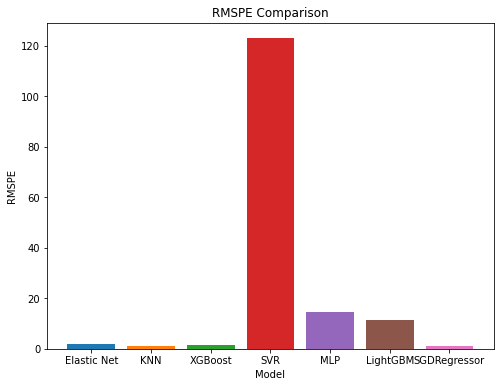

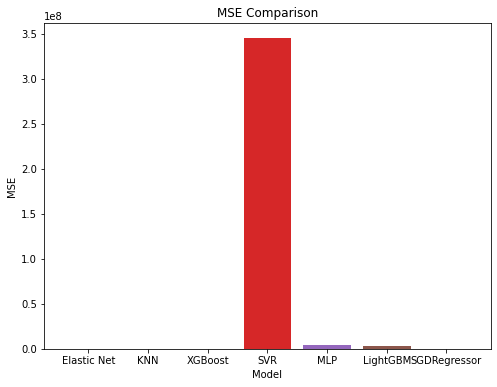

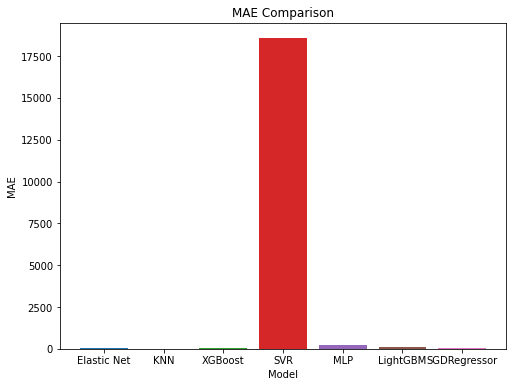

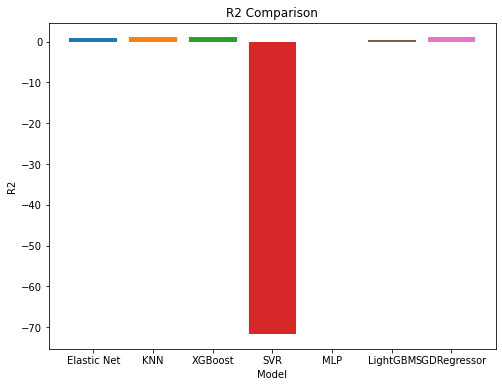

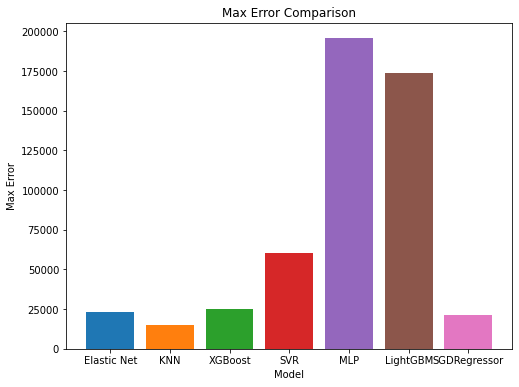

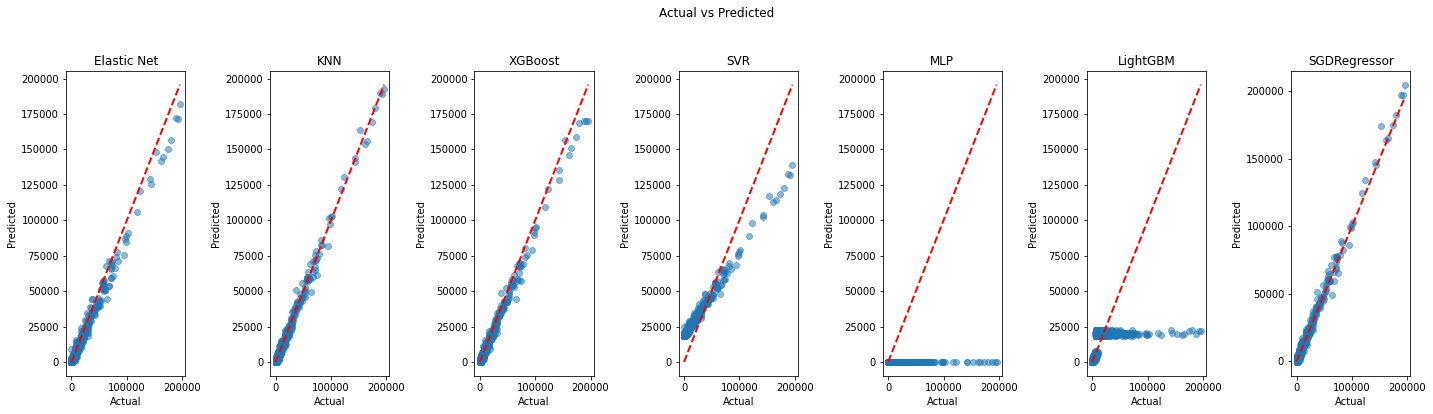

In [114]:
# Evaluate the models
metrics = ['RMSPE', 'MSE', 'MAE', 'R2', 'Max Error']
models = ['Elastic Net', 'KNN', 'XGBoost', 'SVR', 'MLP', 'LightGBM', 'SGDRegressor']
predictions = [enet_pred, knn_pred, xgb_pred, svr_pred, mlp_pred, lgbm_pred, sgd_pred]

# Iterate over each metric
for metric in metrics:
   plt.figure(figsize=(8, 6))
   
   # Iterate over each model and its predictions
   for model, pred in zip(models, predictions):
       # Calculate the score based on the metric
       if metric == 'RMSPE':
           score = np.sqrt(mean_squared_error(y_test, pred)) / np.mean(y_test)
       elif metric == 'MSE':
           score = mean_squared_error(y_test, pred)
       elif metric == 'MAE':
           score = mean_absolute_error(y_test, pred)
       elif metric == 'R2':
           score = r2_score(y_test, pred)
       else:  # Max Error
           score = max_error(y_test, pred)
       
       # Plot the score for the current model
       plt.bar(model, score)
   
   # Set the plot title, x-label, and y-label
   plt.title(f'{metric} Comparison')
   plt.xlabel('Model')
   plt.ylabel(metric)
   plt.show()

# Plot actual vs predicted for each model
fig, axs = plt.subplots(1, len(models), figsize=(20, 6))
fig.suptitle('Actual vs Predicted')

# Iterate over each model and its predictions
for i, (model, pred) in enumerate(zip(models, predictions)):
   # Scatter plot of actual vs predicted values
   axs[i].scatter(y_test, pred, alpha=0.5)
   
   # Plot the diagonal line representing perfect predictions
   axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
   
   # Set the x-label, y-label, and title for each subplot
   axs[i].set_xlabel('Actual')
   axs[i].set_ylabel('Predicted')
   axs[i].set_title(model)

# Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [144]:
# Initialize a dictionary to hold the metrics
metrics_results = {'Model': models}

# Calculate metrics for each model and store in dictionary
for metric in metrics:
    metric_scores = []
    for pred in predictions:
        if metric == 'RMSPE':
            score = np.sqrt(mean_squared_error(y_test, pred)) / np.mean(y_test)
        elif metric == 'MSE':
            score = mean_squared_error(y_test, pred)
        elif metric == 'MAE':
            score = mean_absolute_error(y_test, pred)
        elif metric == 'R2':
            score = r2_score(y_test, pred)
        else:  # Max Error
            score = max_error(y_test, pred)
        metric_scores.append(score)
    metrics_results[metric] = metric_scores

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(metrics_results)

# Display the DataFrame
print(results_df)

          Model       RMSPE           MSE           MAE         R2  \
0   Elastic Net    1.886106  8.118814e+04     34.225979   0.982914   
1           KNN    1.100272  2.762870e+04     17.442385   0.994186   
2       XGBoost    1.581858  5.710773e+04     22.355831   0.987982   
3           SVR  122.990761  3.452273e+08  18572.567688 -71.653380   
4           MLP   14.430282  4.752365e+06    241.475471  -0.000139   
5      LightGBM   11.255675  2.891367e+06     81.230342   0.391509   
6  SGDRegressor    1.239230  3.504805e+04     23.424633   0.992624   

       Max Error  
0   23307.355715  
1   14994.037825  
2   25384.724208  
3   60207.733469  
4  195682.438640  
5  174012.451551  
6   21433.311645  


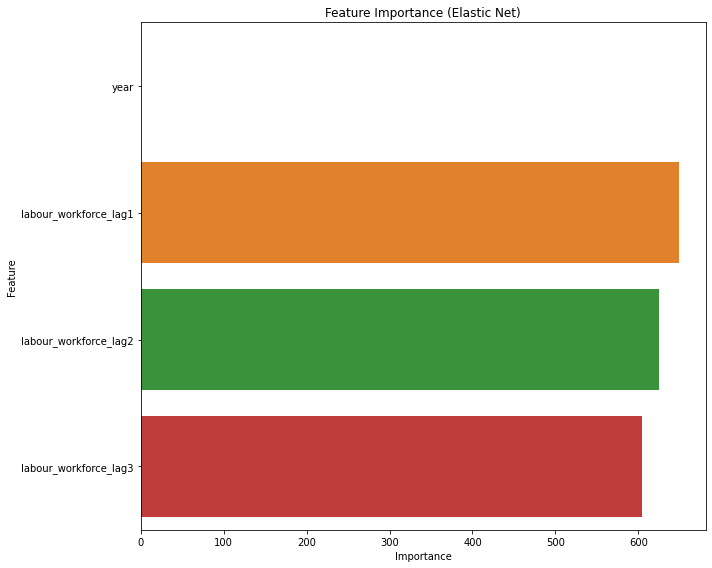

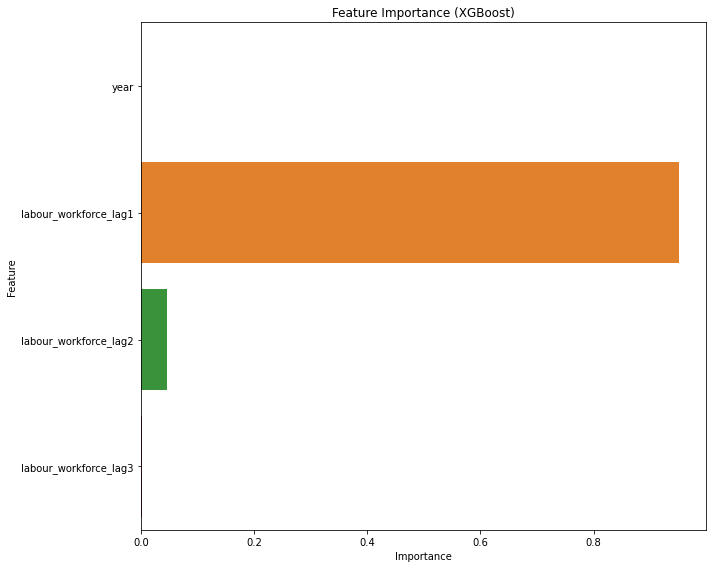

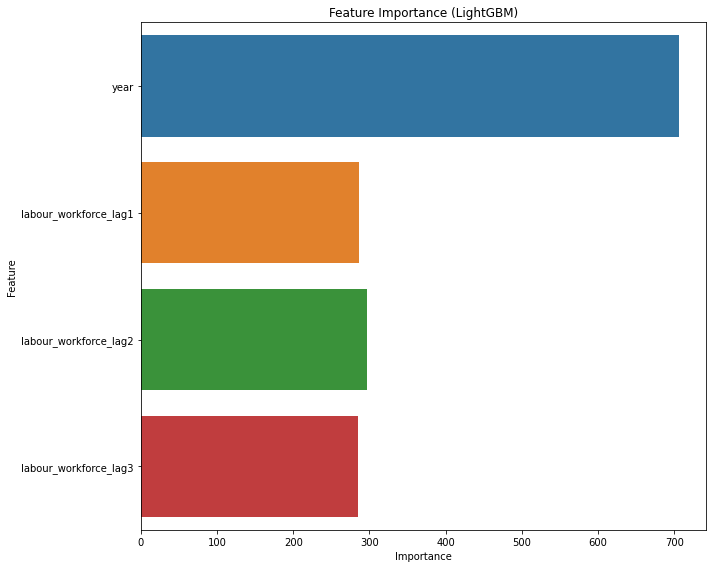

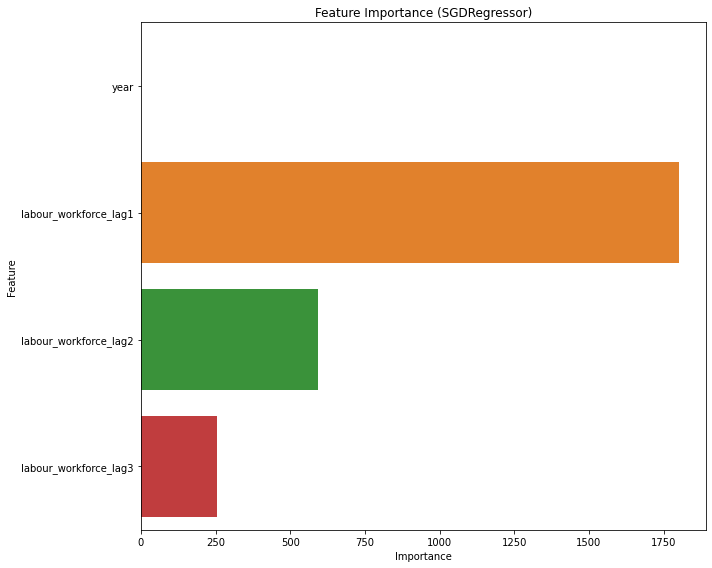

In [115]:
# Plot feature importance for Elastic Net
if hasattr(enet_model, 'coef_'):
   feature_importance_enet = pd.Series(enet_model.coef_, index=X_train.columns)
   plt.figure(figsize=(10, 8))
   sns.barplot(x=feature_importance_enet.abs(), y=feature_importance_enet.index)
   plt.title('Feature Importance (Elastic Net)')
   plt.xlabel('Importance')
   plt.ylabel('Feature')
   plt.tight_layout()
   plt.show()

# Plot feature importance for XGBoost
if hasattr(xgb_model, 'feature_importances_'):
   feature_importance_xgb = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
   plt.figure(figsize=(10, 8))
   sns.barplot(x=feature_importance_xgb, y=feature_importance_xgb.index)
   plt.title('Feature Importance (XGBoost)')
   plt.xlabel('Importance')
   plt.ylabel('Feature')
   plt.tight_layout()
   plt.show()

# Plot feature importance for LightGBM
if hasattr(lgbm_model, 'feature_importances_'):
   feature_importance_lgbm = pd.Series(lgbm_model.feature_importances_, index=X_train.columns)
   plt.figure(figsize=(10, 8))
   sns.barplot(x=feature_importance_lgbm, y=feature_importance_lgbm.index)
   plt.title('Feature Importance (LightGBM)')
   plt.xlabel('Importance')
   plt.ylabel('Feature')
   plt.tight_layout()
   plt.show()

# Plot feature importance for SGDRegressor
if hasattr(sgd_model, 'coef_'):
   feature_importance_sgd = pd.Series(sgd_model.coef_, index=X_train.columns)
   plt.figure(figsize=(10, 8))
   sns.barplot(x=feature_importance_sgd.abs(), y=feature_importance_sgd.index)
   plt.title('Feature Importance (SGDRegressor)')
   plt.xlabel('Importance')
   plt.ylabel('Feature')
   plt.tight_layout()
   plt.show()

# other models do not have "feature importance" per definition (i think double check)

In [145]:
# Initialize a dictionary to hold feature importances
feature_importances = {}

# Check if Elastic Net model has coefficients and add to dictionary
if hasattr(enet_model, 'coef_'):
    feature_importances['Elastic Net'] = pd.Series(enet_model.coef_, index=X_train.columns).abs()

# Check if XGBoost model has feature importances and add to dictionary
if hasattr(xgb_model, 'feature_importances_'):
    feature_importances['XGBoost'] = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Check if LightGBM model has feature importances and add to dictionary
if hasattr(lgbm_model, 'feature_importances_'):
    feature_importances['LightGBM'] = pd.Series(lgbm_model.feature_importances_, index=X_train.columns)

# Check if SGDRegressor has coefficients and add to dictionary
if hasattr(sgd_model, 'coef_'):
    feature_importances['SGDRegressor'] = pd.Series(sgd_model.coef_, index=X_train.columns).abs()

# Create a DataFrame from the dictionary
importances_df = pd.DataFrame(feature_importances)

# Sort features by importance for better visualization (optional, here using the mean importance across models)
importances_df['mean_importance'] = importances_df.mean(axis=1)
importances_df.sort_values(by='mean_importance', ascending=False, inplace=True)
importances_df.drop(columns='mean_importance', inplace=True)

# Display the DataFrame
print(importances_df)

                       Elastic Net   XGBoost  LightGBM  SGDRegressor
labour_workforce_lag1   648.768200  0.950335       287   1800.304052
labour_workforce_lag2   625.144383  0.046432       297    591.474032
labour_workforce_lag3   604.121075  0.002569       285    254.546993
year                      0.000000  0.000665       706      2.111804


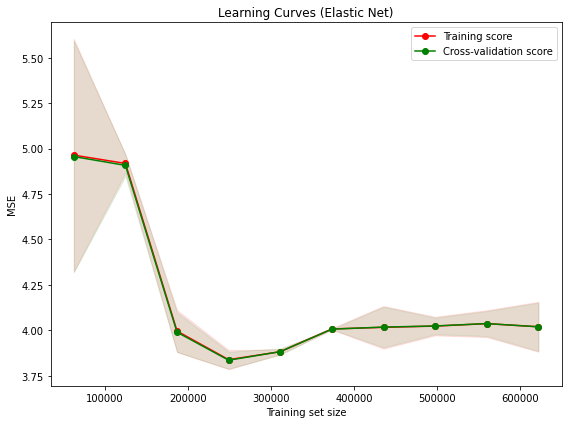

KeyboardInterrupt: 

In [116]:
# Function to plot learning curves
def plot_learning_curves(model, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=2, scoring='neg_mean_squared_log_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.1)
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color="g", alpha=0.1)
    plt.title(f'Learning Curves ({model_name})')
    plt.xlabel('Training set size')
    plt.ylabel('MSE')
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Assuming models and data are loaded
plot_learning_curves(enet_model, X_train_scaled, y_train, "Elastic Net")
plot_learning_curves(knn_model, X_train_scaled, y_train, "KNN")
plot_learning_curves(xgb_model, X_train_scaled, y_train, "XGBoost")
plot_learning_curves(svr_model, X_train_scaled, y_train, "SVR")
plot_learning_curves(mlp_model, X_train_scaled, y_train, "MLP")
plot_learning_curves(lgbm_model, X_train_scaled, y_train, "LightGBM")
plot_learning_curves(sgd_model, X_train_scaled, y_train, "SGDRegressor")

### GUI for Forecasting

In [123]:
# Function to plot model predictions vs actual values based on user selections
def plot_predictions(gender, status, occupation, qualification, industry, country):
    # Filter the data based on user selections
    filtered_df = combined_df[(combined_df['gender'] == gender) &
                              (combined_df['status'] == status) &
                              (combined_df['occupation'] == occupation) &
                              (combined_df['qualification'] == qualification) &
                              (combined_df['industry'] == industry) &
                              (combined_df['country'] == country) &
                              (combined_df['year'] >= 1990) &
                              (combined_df['year'] <= 2024)]
    
    # Prepare the data for prediction
    X_filtered = filtered_df[['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3']]
                               #'labour_workforce_lag4', 'labour_workforce_lag5']]
    X_filtered_scaled = scaler.transform(X_filtered[X_train.columns])
    
    # Create a new DataFrame for extended predictions
    extended_years = range(2024, 2036)
    extended_df = pd.DataFrame({'year': extended_years})
    
    # Initialize lag features for the extended DataFrame
    extended_df['labour_workforce_lag1'] = filtered_df['labour_workforce'].iloc[-1]
    extended_df['labour_workforce_lag2'] = filtered_df['labour_workforce'].iloc[-2]
    extended_df['labour_workforce_lag3'] = filtered_df['labour_workforce'].iloc[-3]
    # extended_df['labour_workforce_lag4'] = filtered_df['labour_workforce'].iloc[-4]
    # extended_df['labour_workforce_lag5'] = filtered_df['labour_workforce'].iloc[-5]
    
    # Make predictions using the models
    enet_pred = enet_model.predict(X_filtered_scaled)
    knn_pred = knn_model.predict(X_filtered_scaled)
    xgb_pred = xgb_model.predict(X_filtered_scaled)
    svr_pred = svr_model.predict(X_filtered_scaled)
    mlp_pred = mlp_model.predict(X_filtered_scaled)
    lgbm_pred = lgbm_model.predict(X_filtered_scaled)
    sgd_pred = sgd_model.predict(X_filtered_scaled)
    
    # Initialize lists to store extended predictions
    enet_extended_pred = []
    knn_extended_pred = []
    xgb_extended_pred = []
    svr_extended_pred = []
    mlp_extended_pred = []
    lgbm_extended_pred = []
    sgd_extended_pred = []

    # Create separate DataFrames for each model's extended predictions
    enet_extended_df = extended_df.copy()
    knn_extended_df = extended_df.copy()
    xgb_extended_df = extended_df.copy()
    svr_extended_df = extended_df.copy()
    mlp_extended_df = extended_df.copy()
    lgbm_extended_df = extended_df.copy()
    sgd_extended_df = extended_df.copy()

    # Loop through extended years and make predictions
    for year in extended_years:
        # Prepare the data for prediction
        X_enet_extended = enet_extended_df[enet_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3',]]
                                                                            #'labour_workforce_lag4', 'labour_workforce_lag5']]
        X_knn_extended = knn_extended_df[knn_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3',]]
                                                                            #'labour_workforce_lag4', 'labour_workforce_lag5']]
        X_xgb_extended = xgb_extended_df[xgb_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3',]]
                                                                            #'labour_workforce_lag4', 'labour_workforce_lag5']]
        X_svr_extended = svr_extended_df[svr_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3',]]
                                                                            #'labour_workforce_lag4', 'labour_workforce_lag5']]
        X_mlp_extended = mlp_extended_df[mlp_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3',]]
                                                                            #'labour_workforce_lag4', 'labour_workforce_lag5']]
        X_lgbm_extended = lgbm_extended_df[lgbm_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3',]]
                                                                            #'labour_workforce_lag4', 'labour_workforce_lag5']]
        X_sgd_extended = sgd_extended_df[sgd_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3',]]
                                                                            #'labour_workforce_lag4', 'labour_workforce_lag5']]
        
        X_enet_extended_scaled = scaler.transform(X_enet_extended[X_train.columns])
        X_knn_extended_scaled = scaler.transform(X_knn_extended[X_train.columns])
        X_xgb_extended_scaled = scaler.transform(X_xgb_extended[X_train.columns])
        X_svr_extended_scaled = scaler.transform(X_svr_extended[X_train.columns])
        X_mlp_extended_scaled = scaler.transform(X_mlp_extended[X_train.columns])
        X_lgbm_extended_scaled = scaler.transform(X_lgbm_extended[X_train.columns])
        X_sgd_extended_scaled = scaler.transform(X_sgd_extended[X_train.columns])
        
        # Make predictions using the models
        enet_pred_year = enet_model.predict(X_enet_extended_scaled)
        knn_pred_year = knn_model.predict(X_knn_extended_scaled)
        xgb_pred_year = xgb_model.predict(X_xgb_extended_scaled)
        svr_pred_year = svr_model.predict(X_svr_extended_scaled)
        mlp_pred_year = mlp_model.predict(X_mlp_extended_scaled)
        lgbm_pred_year = lgbm_model.predict(X_lgbm_extended_scaled)
        sgd_pred_year = sgd_model.predict(X_sgd_extended_scaled)
        
        # Append the predictions to the lists
        enet_extended_pred.append(enet_pred_year[0])
        knn_extended_pred.append(knn_pred_year[0])
        xgb_extended_pred.append(xgb_pred_year[0])
        svr_extended_pred.append(svr_pred_year[0])
        mlp_extended_pred.append(mlp_pred_year[0])
        lgbm_extended_pred.append(lgbm_pred_year[0])
        sgd_extended_pred.append(sgd_pred_year[0])
        
        # Update the lag features for each model's DataFrame for the next iteration
        if year < extended_years[-1]:
            enet_extended_df.loc[enet_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = enet_pred_year[0]
            enet_extended_df.loc[enet_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = enet_pred_year[0]
            enet_extended_df.loc[enet_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = enet_pred_year[0]
            #enet_extended_df.loc[enet_extended_df['year'] == year + 4, 'labour_workforce_lag4'] = enet_pred_year[0]
            #enet_extended_df.loc[enet_extended_df['year'] == year + 5, 'labour_workforce_lag5'] = enet_pred_year[0]
            
            knn_extended_df.loc[knn_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = knn_pred_year[0]
            knn_extended_df.loc[knn_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = knn_pred_year[0]
            knn_extended_df.loc[knn_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = knn_pred_year[0]
            #knn_extended_df.loc[knn_extended_df['year'] == year + 4, 'labour_workforce_lag4'] = knn_pred_year[0]
            #knn_extended_df.loc[knn_extended_df['year'] == year + 5, 'labour_workforce_lag5'] = knn_pred_year[0]
            
            xgb_extended_df.loc[xgb_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = xgb_pred_year[0]
            xgb_extended_df.loc[xgb_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = xgb_pred_year[0]
            xgb_extended_df.loc[xgb_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = xgb_pred_year[0]
            #xgb_extended_df.loc[xgb_extended_df['year'] == year + 4, 'labour_workforce_lag4'] = xgb_pred_year[0]
            #xgb_extended_df.loc[xgb_extended_df['year'] == year + 5, 'labour_workforce_lag5'] = xgb_pred_year[0]
            
            svr_extended_df.loc[svr_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = svr_pred_year[0]
            svr_extended_df.loc[svr_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = svr_pred_year[0]
            svr_extended_df.loc[svr_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = svr_pred_year[0]
            #svr_extended_df.loc[svr_extended_df['year'] == year + 4, 'labour_workforce_lag4'] = svr_pred_year[0]
            #svr_extended_df.loc[svr_extended_df['year'] == year + 5, 'labour_workforce_lag5'] = svr_pred_year[0]
            
            mlp_extended_df.loc[mlp_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = mlp_pred_year[0]
            mlp_extended_df.loc[mlp_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = mlp_pred_year[0]
            mlp_extended_df.loc[mlp_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = mlp_pred_year[0]
            #mlp_extended_df.loc[mlp_extended_df['year'] == year + 4, 'labour_workforce_lag4'] = mlp_pred_year[0]
            #mlp_extended_df.loc[mlp_extended_df['year'] == year + 5, 'labour_workforce_lag5'] = mlp_pred_year[0]
            
            lgbm_extended_df.loc[lgbm_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = lgbm_pred_year[0]
            lgbm_extended_df.loc[lgbm_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = lgbm_pred_year[0]
            lgbm_extended_df.loc[lgbm_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = lgbm_pred_year[0]
            #lgbm_extended_df.loc[lgbm_extended_df['year'] == year + 4, 'labour_workforce_lag4'] = lgbm_pred_year[0]
            #lgbm_extended_df.loc[lgbm_extended_df['year'] == year + 5, 'labour_workforce_lag5'] = lgbm_pred_year[0]
            
            sgd_extended_df.loc[sgd_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = sgd_pred_year[0]
            sgd_extended_df.loc[sgd_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = sgd_pred_year[0]
            sgd_extended_df.loc[sgd_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = sgd_pred_year[0]
            #sgd_extended_df.loc[sgd_extended_df['year'] == year + 4, 'labour_workforce_lag4'] = sgd_pred_year[0]
            #sgd_extended_df.loc[sgd_extended_df['year'] == year + 5, 'labour_workforce_lag5'] = sgd_pred_year[0]
    
    # Set the plot title with all variables
    title = f"Model Predictions vs Actual Values\nGender: {gender}, Status: {status}, Occupation: {occupation},\nQualification: {qualification}, Industry: {industry}, Country: {country}"
    
    # Create subplots for each model
    _, axes = plt.subplots(7, 1, figsize=(16, 20))
    axes = axes.ravel()
    
    # Plot the actual values and model predictions on separate subplots
    for i, (model_name, model_pred, model_extended_pred) in enumerate(zip(['Elastic Net', 'KNN', 'XGBoost', 'Support Vector Regression', 'Multi Layer Perceptron', 'LightGBM', 'SGDRegressor'],
                                                                          [enet_pred, knn_pred, xgb_pred, svr_pred, mlp_pred, lgbm_pred, sgd_pred],
                                                                          [enet_extended_pred, knn_extended_pred, xgb_extended_pred, svr_extended_pred, mlp_extended_pred, lgbm_extended_pred, sgd_extended_pred])):
        ax = axes[i]
        ax.plot(filtered_df['year'], filtered_df['labour_workforce'], label='Actual')
        ax.plot(filtered_df['year'], model_pred, label=model_name)
        ax.plot(extended_years, model_extended_pred, linestyle='--', label=f'{model_name} (Extended)')
        ax.axvspan(1990, 2024, alpha=0.2, color='gray', label='Training')
        ax.axvspan(2024, 2035, alpha=0.2, color='lightblue', label='Forecast')
        ax.set_xlabel('Year')
        ax.set_ylabel('Labour Workforce')
        ax.set_title(f'{model_name} - {title}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


Dropdown(description='Gender', options=('Male', 'Female'), value='Male')

Dropdown(description='Status', options=('Full Time', 'Part Time', 'Self Employed'), value='Full Time')

Dropdown(description='Occupation', options=('Corporate managers and directors', 'Other managers and proprietor…

Dropdown(description='Qualification', options=('Doctorate (QCF8)', 'Other higher degree (QCF7)', 'First degree…

Dropdown(description='Industry', options=('Ind75-54', 'Ind75-47', 'Ind75-46', 'Ind75-16', 'Ind75-44', 'Ind75-4…

Dropdown(description='Country', options=('Northern Ireland', 'Wales', 'England', 'Scotland'), value='Northern …

Button(description='PLOT', style=ButtonStyle())

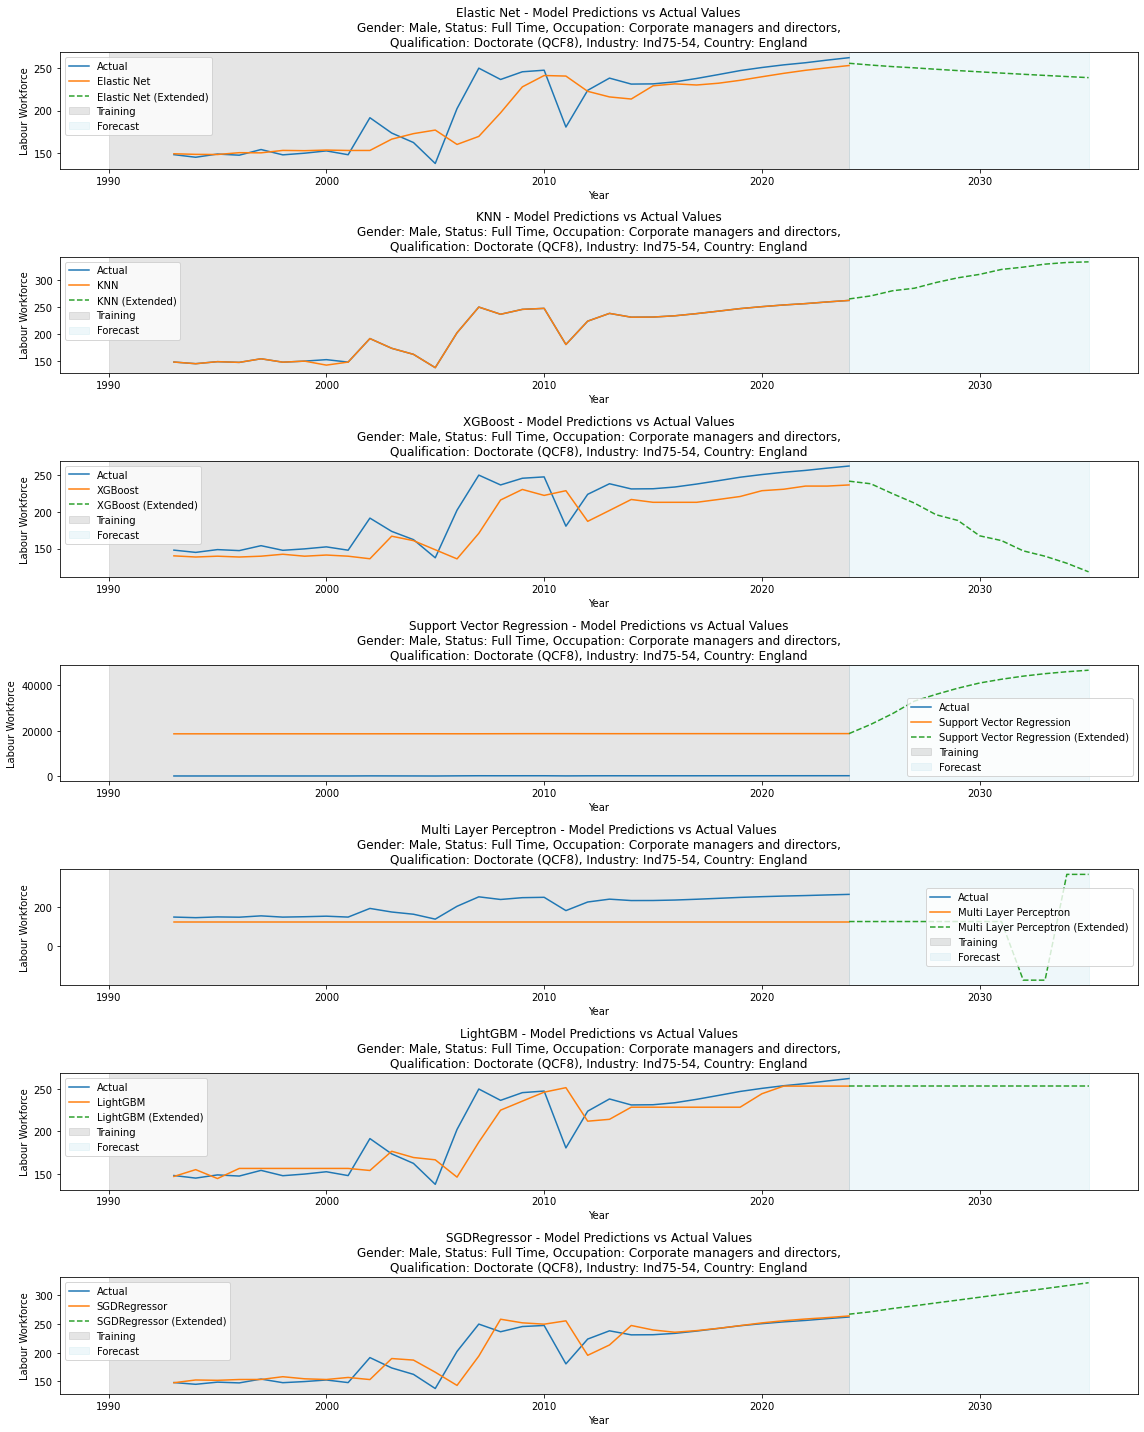

In [124]:
# Create drop-down menus for feature variables
gender_dropdown = widgets.Dropdown(options=combined_df['gender'].unique(), description='Gender')
status_dropdown = widgets.Dropdown(options=combined_df['status'].unique(), description='Status')
occupation_dropdown = widgets.Dropdown(options=combined_df['occupation'].unique(), description='Occupation')
qualification_dropdown = widgets.Dropdown(options=combined_df['qualification'].unique(), description='Qualification')
industry_dropdown = widgets.Dropdown(options=combined_df['industry'].unique(), description='Industry')
country_dropdown = widgets.Dropdown(options=combined_df['country'].unique(), description='Country')

# Create the PLOT button
plot_button = widgets.Button(description='PLOT')

# Tie the plot_predictions function to the button click event
plot_button.on_click(lambda _: plot_predictions(gender_dropdown.value, status_dropdown.value, occupation_dropdown.value, qualification_dropdown.value, industry_dropdown.value, country_dropdown.value))

# Display the drop-down menus and the PLOT button
display(gender_dropdown, status_dropdown, occupation_dropdown, qualification_dropdown, industry_dropdown, country_dropdown, plot_button)

In [138]:
def get_predictions(gender, status, occupation, qualification, industry, country):
    # Filter the data based on user selections
    filtered_df = combined_df[(combined_df['gender'] == gender) &
                              (combined_df['status'] == status) &
                              (combined_df['occupation'] == occupation) &
                              (combined_df['qualification'] == qualification) &
                              (combined_df['industry'] == industry) &
                              (combined_df['country'] == country) &
                              (combined_df['year'] >= 1990) &
                              (combined_df['year'] <= 2024)]
    
    # Prepare the data for prediction
    X_filtered = filtered_df[['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3']]
    X_filtered_scaled = scaler.transform(X_filtered[X_train.columns])
    
    # Create a new DataFrame for extended predictions
    extended_years = range(2024, 2036)
    extended_df = pd.DataFrame({'year': extended_years})
    
    # Initialize lag features for the extended DataFrame
    extended_df['labour_workforce_lag1'] = filtered_df['labour_workforce'].iloc[-1]
    extended_df['labour_workforce_lag2'] = filtered_df['labour_workforce'].iloc[-2]
    extended_df['labour_workforce_lag3'] = filtered_df['labour_workforce'].iloc[-3]
    
    # Make predictions using the models
    enet_pred = enet_model.predict(X_filtered_scaled)
    knn_pred = knn_model.predict(X_filtered_scaled)
    sgd_pred = sgd_model.predict(X_filtered_scaled)
    
    # Initialize lists to store extended predictions
    enet_extended_pred = list(enet_pred)
    knn_extended_pred = list(knn_pred)
    sgd_extended_pred = list(sgd_pred)

    # Create separate DataFrames for each model's extended predictions
    enet_extended_df = extended_df.copy()
    knn_extended_df = extended_df.copy()
    sgd_extended_df = extended_df.copy()

    # Loop through extended years and make predictions
    for year in extended_years:
        # Prepare the data for prediction
        X_enet_extended = enet_extended_df[enet_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3']]
        X_knn_extended = knn_extended_df[knn_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3']]
        X_sgd_extended = sgd_extended_df[sgd_extended_df['year'] == year][['year', 'labour_workforce_lag1', 'labour_workforce_lag2', 'labour_workforce_lag3']]
        
        X_enet_extended_scaled = scaler.transform(X_enet_extended[X_train.columns])
        X_knn_extended_scaled = scaler.transform(X_knn_extended[X_train.columns])
        X_sgd_extended_scaled = scaler.transform(X_sgd_extended[X_train.columns])
        
        # Make predictions using the models
        enet_pred_year = enet_model.predict(X_enet_extended_scaled)
        knn_pred_year = knn_model.predict(X_knn_extended_scaled)
        sgd_pred_year = sgd_model.predict(X_sgd_extended_scaled)
        
        # Append the predictions to the lists
        enet_extended_pred.append(enet_pred_year[0])
        knn_extended_pred.append(knn_pred_year[0])
        sgd_extended_pred.append(sgd_pred_year[0])
        
        # Update the lag features for each model's DataFrame for the next iteration
        if year < extended_years[-1]:
            enet_extended_df.loc[enet_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = enet_pred_year[0]
            enet_extended_df.loc[enet_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = enet_pred_year[0]
            enet_extended_df.loc[enet_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = enet_pred_year[0]
            
            knn_extended_df.loc[knn_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = knn_pred_year[0]
            knn_extended_df.loc[knn_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = knn_pred_year[0]
            knn_extended_df.loc[knn_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = knn_pred_year[0]
            
            sgd_extended_df.loc[sgd_extended_df['year'] == year + 1, 'labour_workforce_lag1'] = sgd_pred_year[0]
            sgd_extended_df.loc[sgd_extended_df['year'] == year + 2, 'labour_workforce_lag2'] = sgd_pred_year[0]
            sgd_extended_df.loc[sgd_extended_df['year'] == year + 3, 'labour_workforce_lag3'] = sgd_pred_year[0]
    
    # Create a dictionary with actual values and model predictions
    predictions_dict = {
        'actual': list(filtered_df['labour_workforce']),
        'knn': knn_extended_pred,
        'sgd': sgd_extended_pred,
        'enet': enet_extended_pred
    }
    
    return predictions_dict

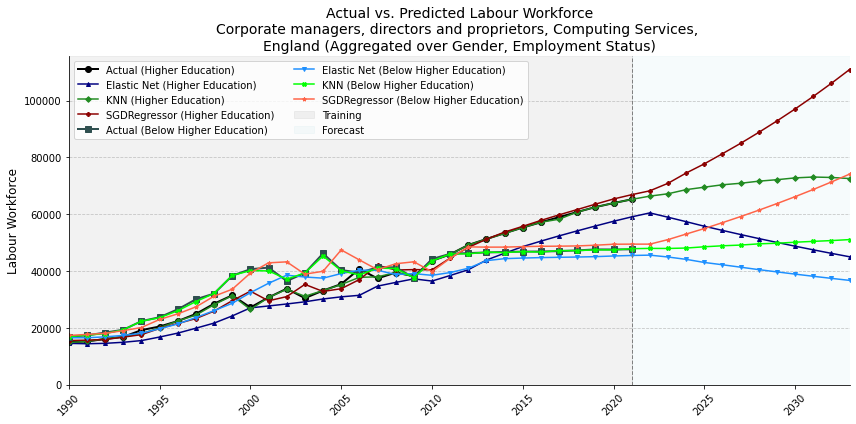

KeyboardInterrupt: 

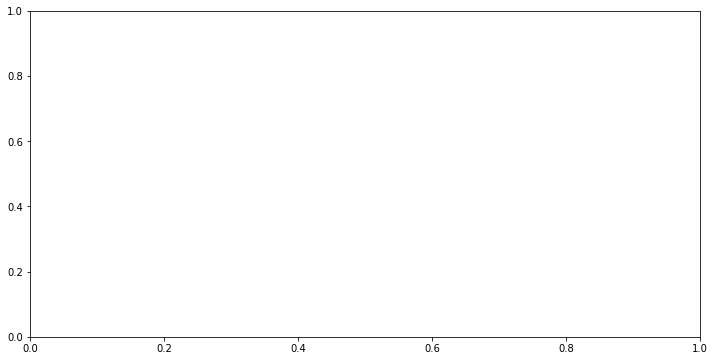

In [143]:
# Define the gender and status combinations
genders = ['Male', 'Female']
statuses = ['Full Time', 'Part Time', 'Self Employed']

# Define the industries
industries = ['Ind75-45', 'Ind75-46', 'Ind75-54', 'Ind75-47']

# Define the qualification groups
qualification_groups = {
   'Higher Education': ['Doctorate (QCF8)', 'Other higher degree (QCF7)', 'First degree (QCF6)'],
   'Below Higher Education': ['Foundation degree; Nursing; Teaching (QCF5)', 'HE below degree level (QCF4)', 'A level & equivalent (QCF3)', 'GCSE (A-C) & equivalent (QCF2)', 'GCSE (below grade C) & equivalent (QCF1)', 'No Qualification']
}

# Define the occupation groups
occupation_groups = {
   'Corporate managers, directors and proprietors': ['Corporate managers and directors', 'Other managers and proprietors'],
   'Science, research, engineering and technology associate/professionals': ['Science, research, engineering and technology professionals', 'Science, engineering and technology associate professionals'],
   'Business, media and public service associate/professionals': ['Business, media and public service professionals', 'Business and public service associate professionals']
}

industry_map = {
    "Ind75-45": "Computing Services", 
    "Ind75-46": "Information Services",
    "Ind75-54": "Scientific Research and Development",
    "Ind75-47": "Financial Services"
}

# Define colors for each model and qualification group
colors = {'Actual': {'Higher Education': 'black', 'Below Higher Education': 'black'},
         'Elastic Net': {'Higher Education': 'navy', 'Below Higher Education': 'dodgerblue'},
         'KNN': {'Higher Education': 'forestgreen', 'Below Higher Education': 'lime'},
         'SGDRegressor': {'Higher Education': 'darkred', 'Below Higher Education': 'tomato'}}

markers = {'Actual': {'Higher Education': 'o', 'Below Higher Education': 's'},
          'Elastic Net': {'Higher Education': '^', 'Below Higher Education': 'v'},
          'KNN': {'Higher Education': 'D', 'Below Higher Education': 'X'},
          'SGDRegressor': {'Higher Education': 'P', 'Below Higher Education': '*'}}

# Iterate over industries
for industry in industries:
   # Iterate over occupation groups
   for occupation_group_name, occupations in occupation_groups.items():
       # Create a plot for the current industry and occupation group
       fig, ax = plt.subplots(figsize=(12, 6))

       # Determine the end of actual data
       actual_end = None

       # Iterate over qualification groups
       for group_name, qualifications in qualification_groups.items():
           # Initialize dictionaries to store the summed actual values and model predictions
           summed_actual = {}
           summed_enet_predictions = {}
           summed_knn_predictions = {}
           summed_sgd_predictions = {}

           # Iterate over genders and statuses
           for gender in genders:
               for status in statuses:
                   # Iterate over qualifications within the current group
                   for qualification in qualifications:
                       # Iterate over occupations within the current occupation group
                       for occupation in occupations:
                           # Call the get_predictions function with the current gender, status, industry, qualification, and occupation
                           predictions_dict = get_predictions(gender=gender,
                                                              status=status,
                                                              occupation=occupation,
                                                              qualification=qualification,
                                                              industry=industry,
                                                              country='England')
                           
                           # Sum the actual values and model predictions
                           if 'actual' not in summed_actual:
                               summed_actual['actual'] = predictions_dict['actual']
                           else:
                               summed_actual['actual'] = [x + y for x, y in zip(summed_actual['actual'], predictions_dict['actual'])]
                           
                           if 'enet' not in summed_enet_predictions:
                               summed_enet_predictions['enet'] = predictions_dict['enet']
                           else:
                               summed_enet_predictions['enet'] = [x + y for x, y in zip(summed_enet_predictions['enet'], predictions_dict['enet'])]
                           
                           if 'knn' not in summed_knn_predictions:
                               summed_knn_predictions['knn'] = predictions_dict['knn']
                           else:
                               summed_knn_predictions['knn'] = [x + y for x, y in zip(summed_knn_predictions['knn'], predictions_dict['knn'])]
                           
                           if 'sgd' not in summed_sgd_predictions:
                               summed_sgd_predictions['sgd'] = predictions_dict['sgd']
                           else:
                               summed_sgd_predictions['sgd'] = [x + y for x, y in zip(summed_sgd_predictions['sgd'], predictions_dict['sgd'])]

           # Create a range of years from 1990 to the end of actual data
           actual_years = range(1990, 1990 + len(summed_actual['actual']))
           actual_end = actual_years[-1]
           predicted_years = range(1990, 1990 + len(summed_enet_predictions['enet']))

           # Plot the actual values and model predictions for the current qualification group
           ax.plot(actual_years, summed_actual['actual'], label=f'Actual ({group_name})', linewidth=2, color=colors['Actual'][group_name], marker=markers['Actual'][group_name], markersize=6)
           ax.plot(predicted_years, summed_enet_predictions['enet'], label=f'Elastic Net ({group_name})', linewidth=1.5, color=colors['Elastic Net'][group_name], marker=markers['Elastic Net'][group_name], markersize=4)
           ax.plot(predicted_years, summed_knn_predictions['knn'], label=f'KNN ({group_name})', linewidth=1.5, color=colors['KNN'][group_name], marker=markers['KNN'][group_name], markersize=4)
           ax.plot(predicted_years, summed_sgd_predictions['sgd'], label=f'SGDRegressor ({group_name})', linewidth=1.5, color=colors['SGDRegressor'][group_name], marker=markers['SGDRegressor'][group_name], markersize=4)

       # Add vertical line to separate actual values and predictions
       ax.axvline(x=actual_end, color='gray', linestyle='--', linewidth=1)

       # Add training and forecast shaded regions
       ax.axvspan(1990, actual_end, alpha=0.1, color='gray', label='Training')
       ax.axvspan(actual_end, predicted_years[-1], alpha=0.1, color='lightblue', label='Forecast')

       # Set x-axis limits
       ax.set_xlim(1990, predicted_years[-1])

       # Set y-axis label and limits
       ax.set_ylabel('Labour Workforce', fontsize=12)
       ax.set_ylim(bottom=0)

       # Set x-axis ticks and labels
       ax.set_xticks(range(1990, predicted_years[-1]+1, 5))
       ax.set_xticklabels(range(1990, predicted_years[-1]+1, 5), rotation=45, fontsize=10)

       # Set title and subtitle
       title = f'Actual vs. Predicted Labour Workforce'
       subtitle = f'{industry_map[industry]}: {occupation_group_name} \nEngland (Aggregated over Gender, Employment Status)'
       ax.set_title(f'{title}\n{subtitle}', fontsize=14)

       # Add legend
       ax.legend(fontsize=10, loc='upper left', ncol=2)

       # Remove top and right spines
       ax.spines['top'].set_visible(False)
       ax.spines['right'].set_visible(False)

       # Add grid lines
       ax.grid(axis='y', linestyle='--', alpha=0.7)

       # Adjust layout and display the plot
       fig.tight_layout()
       plt.show()